In [331]:
import numpy as np
import json
import random
import argparse
import os

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.distributions.multivariate_normal as mvn
from torch.nn.utils import spectral_norm

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image, ImageDraw

In [332]:
# this architecture is for dsprites or 3dshapes dataset

In [333]:
# parser = argparse.ArgumentParser()
# parser.add_argument('-lrd', '--learning_rate_disc', default=2e-5, type=float)
# parser.add_argument('-lrg', '--learning_rate_gen', default=2e-5, type=float)
# parser.add_argument('-b', '--batch_size', default=256, type=int)
# parser.add_argument('-e', '--epochs', default=50, type=int)
# args = parser.parse_args()

In [334]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [335]:
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  1123


In [336]:
# batch_size = args.batch_size
# lrd = args.learning_rate_disc
# lrg = args.learning_rate_gen
# epochs = args.epochs

batch_size = 256
lr = 1e-4
epochs = 10

betas = [0.5, 0.999]

# Check for cuda
use_cuda = torch.cuda.is_available()

EPS = 1e-6

In [337]:
# train_data = torch.from_numpy(np.load('../dsprites/dsprites_data_train.npy')).unsqueeze(1).float()
# train_labels = torch.from_numpy(np.load('../dsprites/dsprites_latent_values_train.npy')).float()
# test_data = torch.from_numpy(np.load('../dsprites/dsprites_data_test.npy')).unsqueeze(1).float()
# test_labels = torch.from_numpy(np.load('../dsprites/dsprites_latent_values_test.npy')).float()

In [338]:
# train_dataset = torch.utils.data.TensorDataset(train_data,train_labels)
# test_dataset = torch.utils.data.TensorDataset(test_data,test_labels)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [339]:
class Encoder(nn.Module):
    def __init__(self, in_channels = 1, num_hiddens = 128):
        super(Encoder, self).__init__()
        
        self.num_hiddens = num_hiddens

        
        self._conv_0 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        self._conv_1 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)

        
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)

        

    def forward(self, inputs):

        x = F.leaky_relu(self._conv_0(inputs), 0.2, inplace=True)
        
        x = self._conv_1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        
        x = self._conv_2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        
        x = self._conv_3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        

        return x.view(-1, self.num_hiddens*8)

In [340]:
class nbnEncoder(nn.Module):
    def __init__(self, in_channels = 1, num_hiddens = 128):
        super(nbnEncoder, self).__init__()
        
        self.num_hiddens = num_hiddens

        
        self._conv_0 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        self._conv_1 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)

        
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)

        

    def forward(self, inputs):

        x = F.relu(self._conv_0(inputs), inplace=True)
        
        x = self._conv_1(x)
        x = F.relu(x, inplace=True)
        
        x = self._conv_2(x)
        x = F.relu(x, inplace=True)
        
        x = self._conv_3(x)
        x = F.relu(x, inplace=True)
        

        return x.view(-1, self.num_hiddens*8)

In [341]:
class bnEncoder(nn.Module):
    def __init__(self, in_channels = 1, num_hiddens = 128):
        super(bnEncoder, self).__init__()

        self.num_hiddens = num_hiddens


        self._conv_0 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self.bn0 = nn.BatchNorm2d(num_hiddens//4)
        self._conv_1 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(num_hiddens//4)

        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)


        self.bn2 = nn.BatchNorm2d(num_hiddens//2)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self.bn3 = nn.BatchNorm2d(num_hiddens//2)

    def forward(self, inputs):

        x = F.relu(self.bn0(self._conv_0(inputs)), inplace=True)

        x = self.bn1(self._conv_1(x))
        x = F.relu(x, inplace=True)

        x = self.bn2(self._conv_2(x))
        x = F.relu(x, inplace=True)

        x = self.bn3(self._conv_3(x))
        x = F.relu(x, inplace=True)


        return x.view(-1, self.num_hiddens*8)

In [342]:
# class Encoder(nn.Module):
#     def __init__(self, in_channels = 1, num_hiddens = 128):
#         super(Encoder, self).__init__()
        
#         self.num_hiddens = num_hiddens

        
#         self._conv_0 = nn.Conv2d(in_channels=in_channels,
#                                  out_channels=num_hiddens//4,
#                                  kernel_size=4,
#                                  stride=2, padding=1)
        
#         self._conv_1 = nn.Conv2d(in_channels=num_hiddens//4,
#                                  out_channels=num_hiddens//4,
#                                  kernel_size=4,
#                                  stride=2, padding=1)

        
#         self._conv_2 = nn.Conv2d(in_channels=num_hiddens//4,
#                                  out_channels=num_hiddens//2,
#                                  kernel_size=5,
#                                  stride=2, padding=2)
        
        
#         self._conv_3 = nn.Conv2d(in_channels=num_hiddens//2,
#                                  out_channels=num_hiddens//2,
#                                  kernel_size=4,
#                                  stride=2, padding=1)

        

#     def forward(self, inputs):

#         x = F.leaky_relu(self._conv_0(inputs), 0.2, inplace=True)
        
#         x = self._conv_1(x)
#         x = F.leaky_relu(x, 0.2, inplace=True)
        
#         x = self._conv_2(x)
#         x = F.leaky_relu(x, 0.2, inplace=True)
        
#         x = self._conv_3(x)
#         x = F.leaky_relu(x, 0.2, inplace=True)
        

#         return x.view(-1, self.num_hiddens*8)

In [343]:
class Latents_z1(nn.Module):
    def __init__(self, hidden_dim = 128, z1 = 5):
        super(Latents_z1, self).__init__()

        self.hidden_dim = hidden_dim

        self.z1 = z1

        self._fc1 = nn.Linear(1024, hidden_dim * 2)
#         self.bn1 = nn.BatchNorm1d(hidden_dim*2)

        self._fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
#         self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, self.z1)
        self.fc_log_var = nn.Linear(hidden_dim, self.z1)

    def forward(self, inputs):

        x = self._fc1(inputs)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._fc2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        mean = self.fc_mean(x)
        logvar = self.fc_log_var(x)

        return mean, logvar


In [344]:
class Latents_z2(nn.Module):
    def __init__(self, hidden_dim = 128, z2 = 10):
        super(Latents_z2, self).__init__()

        self.hidden_dim = hidden_dim

        self.z2 = z2

        self._fc1 = nn.Linear(1024, hidden_dim * 2)
#         self.bn1 = nn.BatchNorm1d(hidden_dim*2)

        self._fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
#         self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, self.z2)
        self.fc_log_var = nn.Linear(hidden_dim, self.z2)

    def forward(self, inputs):

        x = self._fc1(inputs)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._fc2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        mean = self.fc_mean(x)
        logvar = self.fc_log_var(x)

        return mean, logvar



In [345]:
class nbnLatents_z2(nn.Module):
    def __init__(self, hidden_dim = 128, z2 = 10):
        super(nbnLatents_z2, self).__init__()

        self.hidden_dim = hidden_dim

        self.z2 = z2

        self._fc1 = nn.Linear(1024, hidden_dim * 2)
#         self.bn1 = nn.BatchNorm1d(hidden_dim*2)

        self._fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
#         self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, self.z2)
        self.fc_log_var = nn.Linear(hidden_dim, self.z2)

    def forward(self, inputs):

        x = self._fc1(inputs)
        x = F.relu(x,inplace=True)

        x = self._fc2(x)
        x = F.relu(x, inplace=True)

        mean = self.fc_mean(x)
        logvar = self.fc_log_var(x)

        return mean, logvar

In [346]:
class bnLatents_z2(nn.Module):
    def __init__(self, hidden_dim = 128, z2 = 10):
        super(bnLatents_z2, self).__init__()

        self.hidden_dim = hidden_dim

        self.z2 = z2

        self._fc1 = nn.Linear(1024, hidden_dim * 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim * 2)

        self._fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, self.z2)
        self.fc_log_var = nn.Linear(hidden_dim, self.z2)

    def forward(self, inputs):

        x = self.bn1(self._fc1(inputs))
        x = F.relu(x, inplace=True)

        x = self.bn2(self._fc2(x))
        x = F.relu(x, inplace=True)

        mean = self.fc_mean(x)
        logvar = self.fc_log_var(x)

        return mean, logvar



In [347]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim = 64):
        super().__init__()
        # hidden dim has to be smaller (32)
        
        # has to have linear layers
        self._fc1 = spectral_norm(nn.Linear(1024, hidden_dim * 2))
#         self.bn = nn.BatchNorm1d(hidden_dim*2)
        self._fc2 = nn.Linear(hidden_dim*2,1)

    def forward(self, x):
        x = F.leaky_relu(self._fc1(x), 0.2, inplace=True)
        output = torch.sigmoid(self._fc2(x))

        return output.view(-1)

In [348]:
class Discriminator1(nn.Module):
    def __init__(self, hidden_dim = 64, num_hiddens=128, in_channels=1):
        super().__init__()
        # hidden dim has to be smaller (32)
        self.num_hiddens = num_hiddens


        self._conv_0 = spectral_norm(nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1))

        self._conv_1 = spectral_norm(nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1))


        self._conv_2 = spectral_norm(nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1))


        self._conv_3 = spectral_norm(nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1))

        # has to have linear layers
        self._fc1 = spectral_norm(nn.Linear(1024, hidden_dim * 2))
#         self.bn = nn.BatchNorm1d(hidden_dim*2)
        self._fc2 = nn.Linear(hidden_dim*2,1)

    def forward(self, inputs):
        x = F.leaky_relu(self._conv_0(inputs), 0.2, inplace=True)

        x = self._conv_1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._conv_2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._conv_3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = x.view(-1, self.num_hiddens*8)


        x = F.leaky_relu(self._fc1(x), 0.2, inplace=True)
        output = torch.sigmoid(self._fc2(x))

        return output.view(-1)

In [349]:
class Decoder(nn.Module):
    def __init__(self, latent_dim = 10, hidden_dim = 256, num_hiddens = 128, out_channels=1):
        super(Decoder, self).__init__()

        self.num_hiddens = num_hiddens

        self._fc1 = nn.Linear(latent_dim, hidden_dim//2)
        self.fcbn1 = nn.BatchNorm1d(hidden_dim//2)

        self._fc2 = nn.Linear(hidden_dim//2, 1024)
        self.fcbn2 = nn.BatchNorm1d(1024)

#         self._tconv1 = nn.ConvTranspose2d(1024, num_hiddens*2, 1, 1)
#         self.bn1 = nn.BatchNorm2d(num_hiddens*2)

        # num_hiddens is 256

        # the exact inverse of the encoder
        self._tconv2 = nn.ConvTranspose2d(num_hiddens//2, num_hiddens//2, kernel_size=4, stride=2, padding =1)
        self.bn2 = nn.BatchNorm2d(num_hiddens//2)

        self._tconv3 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(num_hiddens//4)

        self._tconv4 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(num_hiddens//4)



        self._tconv5 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=out_channels,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self.fcbn1(self._fc1(inputs))
        x = F.leaky_relu(x, 0.2, inplace=True)


        x = self.fcbn2(self._fc2(x))
        x = F.leaky_relu(x, 0.2, inplace=True)

#         x = self.bn1(self._tconv1(x.view(-1,64,4,4)))
#         x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.bn2(self._tconv2(x.view(-1,64,4,4)))
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.bn3(self._tconv3(x))
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.bn4(self._tconv4(x))
        x = F.leaky_relu(x, 0.2, inplace=True)

        return torch.sigmoid(self._tconv5(x))

In [350]:
class nbnDecoder(nn.Module):
    def __init__(self, latent_dim = 10, hidden_dim = 256, num_hiddens = 128, out_channels=1):
        super(nbnDecoder, self).__init__()
        
        self.num_hiddens = num_hiddens
        
        self._fc1 = nn.Linear(latent_dim, hidden_dim//2)
        
        self._fc2 = nn.Linear(hidden_dim//2, 1024)
        

        # the exact inverse of the encoder
        self._tconv2 = nn.ConvTranspose2d(num_hiddens//2, num_hiddens//2, kernel_size=4, stride=2, padding =1)
        
        self._tconv3 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=num_hiddens//4,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._tconv4 = nn.ConvTranspose2d(in_channels=num_hiddens//4, 
                                                out_channels=num_hiddens//4,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        

        self._tconv5 = nn.ConvTranspose2d(in_channels=num_hiddens//4, 
                                                out_channels=out_channels,
                                                kernel_size=4, 
                                                stride=2, padding=1)

        
    def forward(self, inputs):
        x = self._fc1(inputs)
        x = F.relu(x, inplace=True)
        
        
        x = self._fc2(x)
        x = F.relu(x,inplace=True)
        
        x = self._tconv2(x.view(-1,64,4,4))
        x = F.relu(x,inplace=True)
        
        x = self._tconv3(x)
        x = F.relu(x,inplace=True)
        
        x = self._tconv4(x)
        x = F.relu(x,inplace=True)
        
        return torch.sigmoid(self._tconv5(x))
    

In [351]:
class bnDecoder(nn.Module):
    def __init__(self, latent_dim = 10, hidden_dim = 256, num_hiddens = 128, out_channels=1):
        super(bnDecoder, self).__init__()

        self.num_hiddens = num_hiddens

        self._fc1 = nn.Linear(latent_dim, hidden_dim//2)
        self.bn0 = nn.BatchNorm1d(hidden_dim // 2)

        self._fc2 = nn.Linear(hidden_dim//2, 1024)
        self.bn1 = nn.BatchNorm1d(1024)

        # the exact inverse of the encoder
        self._tconv2 = nn.ConvTranspose2d(num_hiddens//2, num_hiddens//2, kernel_size=4, stride=2, padding =1)
        self.bn2 = nn.BatchNorm2d(num_hiddens//2)

        self._tconv3 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(num_hiddens//4)

        self._tconv4 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(num_hiddens//4)

        self._tconv5 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=out_channels,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self.bn0(self._fc1(inputs))
        x = F.relu(x, inplace=True)


        x = self.bn1(self._fc2(x))
        x = F.relu(x, inplace=True)

        x = self.bn2(self._tconv2(x.view(-1,64,4,4)))
        x = F.relu(x, inplace=True)

        x = self.bn3(self._tconv3(x))
        x = F.relu(x, inplace=True)

        x = self.bn4(self._tconv4(x))
        x = F.relu(x, inplace=True)

        return torch.sigmoid(self._tconv5(x))

In [352]:
class VAE(nn.Module):
    def __init__(self, img_size = (3,64,64), enc_hidden = 256, lat_hidden = 64, dis_hidden = 32, z = 5, dec_hidden = 256, use_cuda=False):

        super(VAE, self).__init__()
        self.use_cuda = use_cuda

        # Parameters
        self.img_size = img_size
        self.num_pixels = img_size[1] * img_size[2]
        self.z = z
        self.channels = img_size[0]

        # Define the encoder
        self.img_to_features = nbnEncoder(in_channels=self.channels)

        # Define the latent encoder
        self.latent_encoder_z = nbnLatents_z2(z2=z)

        self.features_to_img = nbnDecoder(latent_dim=z,out_channels=self.channels)

    def forward(self, data):
        encoded = self.encode(data)
        latent_disc = self.latent_z2(encoded)
        sample = self.sample_gen(latent_disc)
        recons = self.decode(sample)
        return recons, latent_disc

    def encoder(self,x):
        features = self.img_to_features(x)
        latent_disc = self.latent(features)
        return latent_disc

    def init_weights(self):
        self.img_to_features.apply(self.weights_init)
        self.latent_encoder_z.apply(self.weights_init)
        #self.discriminator.apply(self.weights_init)
        #self.crd.apply(self.weights_init)
        #self.discriminator2.apply(self.weights_init)
        self.features_to_img.apply(self.weights_init)

    def weights_init(self,m):

        if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif(type(m) == nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def encode(self, x):

        # Encode image to hidden features
        features = self.img_to_features(x)
        return features

    def latent_z2(self,x):

        latent_disc = self.latent_encoder_z(x)
        return latent_disc

    def discriminate(self,x):
        return self.discriminator(x)

    def discriminate2(self,x):
        return self.discriminator2(x)

    def cr(self,x):

        return self.crd(x)

    def decode(self, latent_sample):

        return self.features_to_img(latent_sample)

    def sample_recons(self, latent_disc):
        return latent_disc[0]

    def sample_gen(self, latent_disc):
        mean, logvar = latent_disc
        std = torch.exp(0.5 * logvar)
        eps = torch.zeros(std.size()).normal_()
        if self.use_cuda:
            eps = eps.cuda()
        return mean + std * eps

In [353]:
class Trainer():
    def __init__(self, model, enc_opt, dis_opt, lat_opt, dec_opt,batch_size, 
                 print_loss_every=100, record_loss_every=10,
                 use_cuda=False):

        # record the losses and everything 
        
        self.model = model
        self.enc_opt = enc_opt
        self.dis_opt = dis_opt
        self.lat_opt = lat_opt
        self.dec_opt = dec_opt
        self.print_loss_every = print_loss_every
        self.record_loss_every = record_loss_every
        self.use_cuda = use_cuda
        self.batch_size = batch_size
        self.label_real = torch.full((batch_size, ), 1, device=device, dtype = torch.float) # see if this is nec
        self.label_gen = torch.full((batch_size, ), 0, device=device, dtype = torch.float)

        if self.use_cuda:
            self.model.cuda()

        # Initialize attributes
        self.num_steps = 0
        self.losses = {'recon': [],'kl': [], 'dis_real':[], 'dis_gen':[], 'vae':[], 'dec_gen':[], 'dec_latent':[]}

        # later can record the kl of each and chuck the ones with a much lower number
        # have a good print statement

    def train(self, data_loader, epochs=10):

        self.model.train()
        for epoch in range(epochs):
            mean_epoch_loss = self._train_epoch(data_loader)
            
            if self.model.training and epoch % self.record_loss_every == 1:
                json1 = json.dumps(self.losses)
                f = open("losses_{}.json".format(self.batch_size),"w")
                f.write(json1)
                f.close()


    def _train_epoch(self, data_loader):

#         epoch_loss = 0.
#         print_every_loss = 0.  # Keeps track of loss to print every
#                                # self.print_loss_every
            
        for batch_idx, (data, label) in enumerate(data_loader):
            iter_loss = self._train_iteration(data)
#             epoch_loss += iter_loss
#             print_every_loss += iter_loss
            # Print loss info every self.print_loss_every iteration
            if batch_idx % self.print_loss_every == 0:
                if batch_idx == 0:
                    for key in self.losses.keys():
                        print('{}:\t{:.3f}'.format(key, self.losses[key][-1]))
                else:   
                    for key in self.losses.keys():
                        print('{}:\t{:.3f}'.format(key, sum(self.losses[key][-100:])/100))
                
        # Return mean epoch loss
        return None

    def _train_iteration(self, data):
        """
        Trains the model for one iteration on a batch of data.
        Parameters
        ----------
        data : torch.Tensor
            A batch of data. Shape (N, C, H, W)
        """

        torch.autograd.set_detect_anomaly(True)
        self.num_steps += 1
        if self.use_cuda:
            data = data.cuda()

        
        self.enc_opt.zero_grad()
        self.dis_opt.zero_grad()
        self.dec_opt.zero_grad()
        self.lat_opt.zero_grad()
        
        # first train the vae, and step the encoder. The variance of it will probably be always 1. 
        # How do we ensure that the variance is less than 1. It is okay. Let try this one first
        
        # train the vae
        real_encoded = self.model.encode(data)
        probs_real = self.model.discriminate(real_encoded)
        latent_disc = self.model.latent(real_encoded)
        recons_sample = self.model.sample_gen(latent_disc)
        recons = self.model.decode(recons_sample)
        real_disc = self.real_disc_loss(probs_real)
        vae = self.vae_loss(data, recons, latent_disc)
        real_disc.backward(retain_graph = True)
                
        k = torch.randint(model.latent_dim, (self.batch_size,1))
        
        gen_sample = self.model.sample_different(recons_sample, self.batch_size, 1, k)
        gen = self.model.decode(gen_sample.detach())
        gen_encoded = self.model.encode(gen.detach())
        recons_encoded = self.model.encode(recons.detach())
        probs_gen = self.model.discriminate(gen_encoded)
        probs_recons = self.model.discriminate(recons_encoded)
        gen_disc = self.gen_disc_loss(probs_gen)
        recons_disc = self.gen_disc_loss(probs_recons)
        fake_disc = (gen_disc + recons_disc)/2
        fake_disc.backward(retain_graph = True)
        self.dis_opt.step()
        self.dec_opt.zero_grad()
        vae.backward(retain_graph = True)
        self.lat_opt.step()
        self.enc_opt.step()
        
        recons = self.model.decode(recons_sample.detach())
        
        gen_encoded_dec = self.model.encode(gen)
        recons_encoded_dec = self.model.encode(recons)
        gen_latent_disc = self.model.latent(gen_encoded_dec)
        recons_latent_disc = self.model.latent(recons_encoded_dec)
        probs_gen_dec = self.model.discriminate(gen_encoded_dec)
        probs_recons_dec = self.model.discriminate(recons_encoded_dec)

        disc_dec = self.disc_dec_loss(probs_gen_dec) + self.disc_dec_loss(probs_recons_dec)
        latent_dec = self.latent_dec_loss(gen_latent_disc, gen_sample.detach()) + \
                        self.latent_dec_loss(recons_latent_disc, recons_sample.detach())
                            
        
        dec = (disc_dec + latent_dec)/2
        dec.backward()
        self.dec_opt.step()
        
        return None


        
#         # train the latent variables part
#         fake_encoded = self.model.encode(fake_imgs)
#         z_recons = self.model.latent(fake_encoded)
#         loss_lat = self._loss_function_lat(z_recons, z)
#         loss_lat.backward(retain_graph = True)
        
#         #train the vae
#         latent_dist = self.model.latent(real_encoded)
#         latent_sample = self.model.reparameterize(latent_dist)
#         recons = self.model.decode(latent_sample)
#         loss_vae = 2*self._loss_function_vae(data, recons, latent_dist)
#         loss_vae.backward()
#         # optimize latents, encoder, discriminator
#         self.optimizerd.step()
        
        
#         #train the generator of infoGAN  
#         fake_encoded = self.model.encode(fake_imgs)
#         probs_gen = self.model.discriminate(fake_encoded)
#         loss_gen = self.bce_loss(probs_gen, self.label_real)
#         loss_gen.backward()
#         self.optimizerg.step() #train the latent model and the generator/decoder
        

#         train_loss = loss_vae+loss_disc+loss_gen +loss_lat
#         return train_loss.item()

    def disc_dec_loss(self, probs_gen):
        loss = F.binary_cross_entropy(probs_gen, self.label_real)
        if self.model.training and self.num_steps % self.record_loss_every == 1:
            self.losses['dec_gen'].append(loss.item())
            
        return loss
    
    
    def weights_init(m):
    
        if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif(type(m) == nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

            
    def latent_dec_loss(self, gen_latent_disc, gen_sample):
        mu, logvar = gen_latent_disc
        var = torch.exp(0.5 * logvar)
        loss = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (gen_sample - mu).pow(2).div(var.mul(2.0) + 1e-6)
        nll = -(loss.sum(1).mean())
        if self.model.training and self.num_steps % self.record_loss_every == 1:
            self.losses['dec_latent'].append(nll.item())
        return nll

    
    def real_disc_loss(self, probs_real):
        loss = F.binary_cross_entropy(probs_real, self.label_real)
        if self.model.training and self.num_steps % self.record_loss_every == 1:
            self.losses['dis_real'].append(loss.item())
            
        return loss   
    
    def gen_disc_loss(self, probs_gen):
        loss = F.binary_cross_entropy(probs_gen, self.label_gen)
        if self.model.training and self.num_steps % self.record_loss_every == 1:
            self.losses['dis_gen'].append(loss.item())
            
        return loss


    def vae_loss(self, data, recon_data, latent_disc):
        
        # Reconstruction loss is pixel wise cross-entropy
        recon_loss = F.binary_cross_entropy(recon_data.view(-1, self.model.num_pixels),
                                            data.view(-1, self.model.num_pixels), reduction='sum')
        recon_loss = recon_loss/data.size()[0]
        
        # F.binary_cross_entropy takes mean over pixels, so unnormalise this
        #recon_loss *= self.model.num_pixels  #check this one out

        
        mean, logvar = latent_disc
        kl_loss = self._kl_normal_loss(mean, logvar)
            
        
        # Calculate total loss
        total_loss = recon_loss + kl_loss

        # Record losses
        if self.model.training and self.num_steps % self.record_loss_every == 1:
            self.losses['recon'].append(recon_loss.item())
            self.losses['kl'].append(kl_loss.item())
            self.losses['vae'].append(total_loss.item())

        return total_loss

    def _kl_normal_loss(self, mean, logvar):

        # Calculate KL divergence
        kl_values = -0.5 * (1 + logvar - mean.pow(2) - logvar.exp())
        # Mean KL divergence across batch for each latent variable
        kl_means = torch.mean(kl_values, dim=0)
        # KL loss is sum of mean KL of each latent variable
        kl_loss = torch.sum(kl_means)

        return kl_loss



In [354]:
#name,epochs,self.dim,self.beta,self.gan,self.lr,self.batch_size,
#self.model.z2,self.crdis,self.gamma,self.real,self.cont_max,self.cont_num_iters

#name,epochs,z1+z2,gan,lrg,lrd,batch_size,z2,args.inter,args.crdis,args.num_inters,
#args.betamax,args.betamin,args.redecode,args.z2recons,args.klflag


#batch_size = 2
if __name__ == "__main__":
    batch_size = 256
    img_size = (3,64,64)
    model = VAE(img_size=img_size, z=10, use_cuda=use_cuda)
    if use_cuda:
        model.cuda()
    checkpoint = torch.load('nbfactweights_e50_d10_b1_lrg0.0001_lrd5e-05_bs128_intperm_gan0_z2recons10_real10_f10_f20_red20.0',map_location=torch.device('cpu'))
#     plots = 'all'
    plots = ['samples', 'reconstruct-traverse']
    loss_file = 'nbfactlosses_e50_d10_b1_lrg0.0001_lrd5e-05_bs64_intperm_gan0_z2recons10_real10_f10_f20_red20.0.json'
    # Define optimizer
    dec_opt = optim.Adam(list(model.features_to_img.parameters()), lr=lr, betas = betas)
    enc_opt = optim.Adam(list(model.img_to_features.parameters()), lr=lr, betas = betas)
    lat_opt = optim.Adam(list(model.latent_encoder_z.parameters()), lr=lr, betas = betas)
    disc_opt = None

    # Define trainer
    trainer = Trainer(model, enc_opt, disc_opt, lat_opt, dec_opt, batch_size,
              use_cuda=use_cuda)

    epochs = 50

In [355]:
## see if this can be used 

# test_data = torch.from_numpy(np.load('tinydsprites_s1_o_y.npy')).float()
test_data = torch.from_numpy(np.load('../3dshapes/3dshapes_test_images.npy')).squeeze(1).permute(0,3,1,2).float()
test_labels = torch.from_numpy(np.load('../3dshapes/3dshapes_test_labels.npy')).float()
# test_labels = torch.from_numpy(np.load('tinydsplabels_s1_o.npy')).float()

test_dataset = torch.utils.data.TensorDataset(test_data,test_labels)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle=True,
drop_last=True)

print(len(test_loader.dataset))

256


In [356]:
################## yann visualizations ########################################

In [357]:
class Visualizer():
    def __init__(self, model, model_dir, loss_file, 
                 save_images=True,
                 loss_of_interest=None,
                 display_loss_per_dim=False,
                 max_traversal=0.475,  # corresponds to ~2 for standard normal
                 upsample_factor=1):
        """
        Visualizer is used to generate images of samples, reconstructions,
        latent traversals and so on of the trained model.
        Parameters
        ----------
        model : disvae.vae.VAE
        dataset : str
            Name of the dataset.
        model_dir : str
            The directory that the model is saved to and where the images will
            be stored.
        save_images : bool, optional
            Whether to save images or return a tensor.
        loss_of_interest : str, optional
            The loss type (as saved in the log file) to order the latent dimensions by and display.
        display_loss_per_dim : bool, optional
            if the loss should be included as text next to the corresponding latent dimension images.
        max_traversal: float, optional
            The maximum displacement induced by a latent traversal. Symmetrical
            traversals are assumed. If `m>=0.5` then uses absolute value traversal,
            if `m<0.5` uses a percentage of the distribution (quantile).
            E.g. for the prior the distribution is a standard normal so `m=0.45` c
            orresponds to an absolute value of `1.645` because `2m=90%%` of a
            standard normal is between `-1.645` and `1.645`. Note in the case
            of the posterior, the distribution is not standard normal anymore.
        upsample_factor : floar, optional
            Scale factor to upsample the size of the tensor
        """
        self.model = model
        self.device = next(self.model.parameters()).device
        self.latent_dim = self.model.z
        self.max_traversal = max_traversal
        self.save_images = save_images
        self.model_dir = model_dir 
        self.dataset = 'dsprites'
        self.upsample_factor = upsample_factor
        if loss_of_interest is not None:
            # get this from your loss file
            self.losses = read_loss_from_file(loss_file)

    def _get_traversal_range(self, mean=0, std=1):
        """Return the corresponding traversal range in absolute terms."""
        max_traversal = self.max_traversal

        if max_traversal < 0.5:
            max_traversal = (1 - 2 * max_traversal) / 2  # from 0.45 to 0.05
            max_traversal = stats.norm.ppf(max_traversal, loc=mean, scale=std)  # from 0.05 to -1.645

        # symmetrical traversals
        return (-1 * max_traversal, max_traversal)

    def _traverse_line(self, idx, n_samples, data=None):
        """Return a (size, latent_size) latent sample, corresponding to a traversal
        of a latent variable indicated by idx.
        Parameters
        ----------
        idx : int
            Index of continuous dimension to traverse. If the continuous latent
            vector is 10 dimensional and idx = 7, then the 7th dimension
            will be traversed while all others are fixed.
        n_samples : int
            Number of samples to generate.
        data : torch.Tensor or None, optional
            Data to use for computing the posterior. Shape (N, C, H, W). If
            `None` then use the mean of the prior (all zeros) for all other dimensions.
        """
        if data is None:
            # mean of prior for other dimensions
            samples = torch.zeros(n_samples, self.latent_dim)
            traversals = torch.linspace(*self._get_traversal_range(), steps=n_samples)

        else:
            if data.size(0) > 1:
                raise ValueError("Every value should be sampled from the same posterior, but {} datapoints given.".format(data.size(0)))

            with torch.no_grad():
                post_mean, post_logvar = self.model.latent_z2(self.model.encode(data.to(self.device)))
                samples = self.model.sample_gen([post_mean, post_logvar])
                samples = samples.cpu().repeat(n_samples, 1)
                post_mean_idx = post_mean.cpu()[0, idx]
                post_std_idx = torch.exp(post_logvar / 2).cpu()[0, idx]

            # travers from the gaussian of the posterior in case quantile
            traversals = torch.linspace(*self._get_traversal_range(mean=post_mean_idx,
                                                                   std=post_std_idx),
                                        steps=n_samples)

        for i in range(n_samples):
            samples[i, idx] = traversals[i]

        return samples

    def _save_or_return(self, to_plot, size, filename, is_force_return=False):
        """Create plot and save or return it."""
        to_plot = F.interpolate(to_plot, scale_factor=self.upsample_factor)

        if size[0] * size[1] != to_plot.shape[0]:
            raise ValueError("Wrong size {} for datashape {}".format(size, to_plot.shape))

        # `nrow` is number of images PER row => number of col
        kwargs = dict(nrow=size[1], pad_value=1)
        if self.save_images and not is_force_return:
            filename = os.path.join(self.model_dir, filename)
            save_image(to_plot, filename, **kwargs)
        else:
            return make_grid_img(to_plot, **kwargs)

    def _decode_latents(self, latent_samples):
        """Decodes latent samples into images.
        Parameters
        ----------
        latent_samples : torch.autograd.Variable
            Samples from latent distribution. Shape (N, L) where L is dimension
            of latent distribution.
        """
        latent_samples = latent_samples.to(self.device)
        return self.model.decode(latent_samples).cpu()

    def generate_samples(self, size=(8, 8)):
        """Plot generated samples from the prior and decoding.
        Parameters
        ----------
        size : tuple of ints, optional
            Size of the final grid.
        """
        prior_samples = torch.randn(size[0] * size[1], self.latent_dim)
        generated = self._decode_latents(prior_samples)
        return self._save_or_return(generated.data, size, PLOT_NAMES["generate_samples"])

    def data_samples(self, data, size=(8, 8)):
        """Plot samples from the dataset
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        size : tuple of ints, optional
            Size of the final grid.
        """
        data = data[:size[0] * size[1], ...]
        return self._save_or_return(data, size, PLOT_NAMES["data_samples"])

    def reconstruct(self, data, size=(8, 8), is_original=True, is_force_return=False):
        """Generate reconstructions of data through the model.
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        size : tuple of ints, optional
            Size of grid on which reconstructions will be plotted. The number
            of rows should be even when `is_original`, so that upper
            half contains true data and bottom half contains reconstructions.contains
        is_original : bool, optional
            Whether to exclude the original plots.
        is_force_return : bool, optional
            Force returning instead of saving the image.
        """
        if is_original:
            if size[0] % 2 != 0:
                raise ValueError("Should be even number of rows when showing originals not {}".format(size[0]))
            n_samples = size[0] // 2 * size[1]
        else:
            n_samples = size[0] * size[1]

        with torch.no_grad():
            originals = data.to(self.device)[:n_samples, ...]
            recs,_ = self.model(originals)

        originals = originals.cpu()
        recs = recs.view(-1, *self.model.img_size).cpu()

        to_plot = torch.cat([originals, recs]) if is_original else recs
        return self._save_or_return(to_plot, size, PLOT_NAMES["reconstruct"],
                                    is_force_return=is_force_return)

    def traversals(self,
                   data=None,
                   is_reorder_latents=True,
                   n_per_latent=8,
                   n_latents=None,
                   is_force_return=False):
        """Plot traverse through all latent dimensions (prior or posterior) one
        by one and plots a grid of images where each row corresponds to a latent
        traversal of one latent dimension.
        Parameters
        ----------
        data : bool, optional
            Data to use for computing the latent posterior. If `None` traverses
            the prior.
        n_per_latent : int, optional
            The number of points to include in the traversal of a latent dimension.
            I.e. number of columns.
        n_latents : int, optional
            The number of latent dimensions to display. I.e. number of rows. If `None`
            uses all latents.
        is_reorder_latents : bool, optional
            If the latent dimensions should be reordered or not
        is_force_return : bool, optional
            Force returning instead of saving the image.
        """
        n_latents = n_latents if n_latents is not None else self.model.latent_dim
        latent_samples = [self._traverse_line(dim, n_per_latent, data=data)
                          for dim in range(self.latent_dim)]
        decoded_traversal = self._decode_latents(torch.cat(latent_samples, dim=0))

        if is_reorder_latents:
            n_images, *other_shape = decoded_traversal.size()
            n_rows = n_images // n_per_latent
            decoded_traversal = decoded_traversal.reshape(n_rows, n_per_latent, *other_shape)
            decoded_traversal = sort_list_by_other(decoded_traversal, self.losses)
            decoded_traversal = torch.stack(decoded_traversal, dim=0)
            decoded_traversal = decoded_traversal.reshape(n_images, *other_shape)
            
        decoded_traversal = decoded_traversal[range(n_per_latent * n_latents), ...]

        size = (n_latents, n_per_latent)
        sampling_type = "prior" if data is None else "posterior"
        filename = "{}_{}".format(sampling_type, PLOT_NAMES["traversals"])

        return self._save_or_return(decoded_traversal.data, size, filename,
                                    is_force_return=is_force_return)

    def reconstruct_traverse(self, data,
                             is_posterior=True,
                             n_per_latent=10,
                             n_latents=None,
                             is_show_text=True):
        """
        Creates a figure whith first row for original images, second are
        reconstructions, rest are traversals (prior or posterior) of the latent
        dimensions.
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        n_per_latent : int, optional
            The number of points to include in the traversal of a latent dimension.
            I.e. number of columns.
        n_latents : int, optional
            The number of latent dimensions to display. I.e. number of rows. If `None`
            uses all latents.
        is_posterior : bool, optional
            Whether to sample from the posterior.
        is_show_text : bool, optional
            Whether the KL values next to the traversal rows.
        """
        n_latents = n_latents if n_latents is not None else self.model.latent_dim

        reconstructions = self.reconstruct(data[:2 * n_per_latent, ...],
                                           size=(2, n_per_latent),
                                           is_force_return=True)
        traversals = self.traversals(data=data[3:4, ...] if is_posterior else None,
                                     is_reorder_latents=True,
                                     n_per_latent=n_per_latent,
                                     n_latents=n_latents,
                                     is_force_return=True)

        concatenated = np.concatenate((reconstructions, traversals), axis=0)
        concatenated = Image.fromarray(concatenated)
        concatenated.show()

        if is_show_text:
            losses = sorted(self.losses, reverse=True)[:n_latents]
            labels = ['orig', 'recon'] + ["KL={:.4f}".format(l) for l in losses]
            concatenated = add_labels(concatenated, labels)

        filename = os.path.join(self.model_dir, PLOT_NAMES["reconstruct_traverse"])
        concatenated.save(filename)

In [358]:
def load_weights(model, checkpoint):
    model.img_to_features.load_state_dict(checkpoint['encoder'])
    model.latent_encoder_z.load_state_dict(checkpoint['latent_z'])
    model.features_to_img.load_state_dict(checkpoint['decoder'])
    model.eval()
    return model

def make_grid_img(tensor, **kwargs):
    """Converts a tensor to a grid of images that can be read by imageio.
    Notes
    -----
    * from in https://github.com/pytorch/vision/blob/master/torchvision/utils.py
    Parameters
    ----------
    tensor (torch.Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
        or a list of images all of the same size.
    kwargs:
        Additional arguments to `make_grid_img`.
    """
    grid = make_grid(tensor, **kwargs)
    img_grid = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0)
    img_grid = img_grid.to('cpu', torch.uint8).numpy()
    return img_grid


# def get_samples
def get_samples(dataset, num_samples, idcs=[]):
    """ Generate a number of samples from the dataset.
    Parameters
    ----------
    dataset : str
        The name of the dataset.
    num_samples : int, optional
        The number of samples to load from the dataset
    idcs : list of ints, optional
        List of indices to of images to put at the begning of the samples.
    """
    data_loader = torch.utils.data.DataLoader(dataset,
                                  batch_size=1,
                                  shuffle=idcs is None)

    idcs += random.sample(range(len(data_loader.dataset)), num_samples - len(idcs))
    samples = torch.stack([data_loader.dataset[i][0] for i in idcs], dim=0)
    print("Selected idcs: {}".format(idcs))

    return samples

def sort_list_by_other(to_sort, other, reverse=True):
    """Sort a list by an other."""
    return [el for _, el in sorted(zip(other, to_sort), reverse=reverse)]

def read_loss_from_file(loss_file):
    with open(loss_file) as f:
        data = json.load(f)
    kllist =[]
    for key in list(data):
        if 'kl_' in key:
            if 'kl_z' not in key:
                kllist.append(np.sum(data[key][-100:])/100)
    return kllist

def add_labels(input_image, labels):
    """Adds labels next to rows of an image.
    Parameters
    ----------
    input_image : image
        The image to which to add the labels
    labels : list
        The list of labels to plot
    """
    new_width = input_image.width + 100
    new_size = (new_width, input_image.height)
    new_img = Image.new("RGB", new_size, color='white')
    new_img.paste(input_image, (0, 0))
    draw = ImageDraw.Draw(new_img)

    for i, s in enumerate(labels):
        draw.text(xy=(new_width - 100 + 0.005,
                      int((i / len(labels) + 1 / (2 * len(labels))) * input_image.height)),
                  text=s,
                  fill=(0, 0, 0))

    return new_img

In [359]:
PLOT_NAMES = dict(generate_samples="samples.png",
                  data_samples="data_samples.png",
                  reconstruct="reconstruct.png",
                  traversals="traversals.png",
                  reconstruct_traverse="reconstruct_traverse.png")
n_rows = 10
#n_rows = model.latent_dim
n_cols = 10

model = VAE(img_size=img_size, z=10, use_cuda=use_cuda)
model = load_weights(model, checkpoint)

dataset = 'dsprites'
    
viz = Visualizer(model=model,
                 model_dir='',
                 max_traversal=2,
                 loss_of_interest='kl_loss', loss_file=loss_file,
                 upsample_factor=1) 
size = (n_rows, n_cols)
# same samples for all plots: sample max then take first `x`data  for all plots
num_samples = n_cols * n_rows
    
samples = get_samples(test_dataset, num_samples)
    
if "all" in plots:
    plots = [p for p in PLOT_TYPES if p != "all"]

# mostly call it with reconstruct-traverse

for plot_type in plots:
    if plot_type == 'generate-samples':
        viz.generate_samples(size=size)
    elif plot_type == 'data-samples':
        viz.data_samples(samples, size=size)
    elif plot_type == "reconstruct":
        viz.reconstruct(samples, size=size)
    elif plot_type == "reconstruct-traverse":
        viz.reconstruct_traverse(samples,
                                 is_posterior=True,
                                 n_latents=n_rows,
                                 n_per_latent=n_cols,
                                 is_show_text=True)

Selected idcs: [143, 77, 255, 130, 236, 3, 196, 129, 11, 118, 201, 74, 218, 9, 17, 41, 124, 1, 238, 55, 151, 82, 174, 246, 116, 212, 177, 144, 90, 110, 59, 123, 4, 102, 16, 69, 207, 211, 153, 98, 224, 83, 65, 170, 235, 163, 114, 205, 239, 71, 42, 181, 162, 26, 24, 79, 5, 73, 45, 225, 149, 145, 113, 99, 220, 95, 126, 36, 52, 58, 93, 188, 0, 228, 128, 136, 184, 15, 222, 34, 221, 155, 152, 100, 20, 38, 204, 226, 106, 104, 229, 137, 134, 173, 61, 138, 213, 54, 141, 33]


In [360]:
##### end yann visualizations ##############################################################

In [361]:
# import pandas as pd
# def read_loss_from_file(log_file_path, loss_to_fetch):
#     """ Read the average KL per latent dimension at the final stage of training from the log file.
#         Parameters
#         ----------
#         log_file_path : str
#             Full path and file name for the log file. For example 'experiments/custom/losses.log'.
#         loss_to_fetch : str
#             The loss type to search for in the log file and return. This must be in the exact form as stored.
#     """
#     EPOCH = "Epoch"
#     LOSS = "Loss"

#     logs = pd.read_csv(log_file_path)
#     df_last_epoch_loss = logs[logs.loc[:, EPOCH] == logs.loc[:, EPOCH].max()]
#     df_last_epoch_loss = df_last_epoch_loss.loc[df_last_epoch_loss.loc[:, LOSS].str.startswith(loss_to_fetch), :]
#     df_last_epoch_loss.loc[:, LOSS] = df_last_epoch_loss.loc[:, LOSS].str.replace(loss_to_fetch, "").astype(int)
#     df_last_epoch_loss = df_last_epoch_loss.sort_values(LOSS).loc[:, "Value"]
#     return list(df_last_epoch_loss)



In [362]:
# read_loss_from_file('test.log', 'kl_loss_')

In [363]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

model.img_to_features.load_state_dict(checkpoint['encoder'])
model.latent_encoder_z.load_state_dict(checkpoint['latent_z'])
model.features_to_img.load_state_dict(checkpoint['decoder'])

model.eval()

(valid_originals, labels) = next(iter(test_loader))
valid_originals = valid_originals.to(device)
latent_dist = model.latent_z2(model.encode(valid_originals))
latent_sample = model.sample_recons(latent_dist)
valid_reconstructions = model.decode(latent_sample)
# valid_reconstructions, _, latent_dist, _,_ = model(valid_originals)

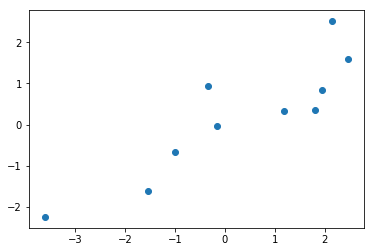

In [364]:
c = 0
import matplotlib.pyplot as plt
plt.scatter(latent_dist[c][0].detach().numpy(), latent_dist[c][1].detach().numpy()) 
#             c = labels[:,0,5].detach().numpy().tolist())
# plt.scatter(latent_dist[c][1].detach().numpy(), np.zeros((32,)), 
#             c = labels[:,0,5].detach().numpy().tolist())

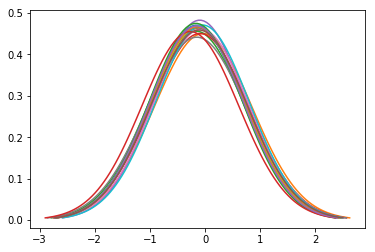

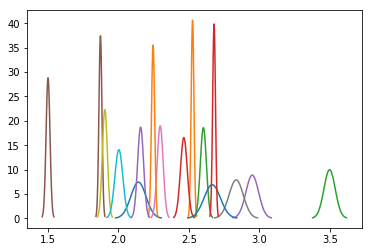

In [365]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math


lat=0
for i in range(16):
    mu = latent_dist[0][i,lat].detach().numpy()
    variance = latent_dist[1][i,lat].exp().detach().numpy()
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    #plt.xlim([-2,2])
    plt.plot(x, stats.norm.pdf(x, mu, sigma))#, c = (labels[i,5].detach().numpy().tolist(),0.2,0.5))
plt.show()
lat=1
for i in range(16):
    mu = latent_dist[0][i,lat].detach().numpy()
    variance = latent_dist[1][i,lat].exp().detach().numpy()
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))#, c = (labels[i,3].detach().numpy().tolist(),0.2,0.5))
plt.show()

In [366]:
# print(latent_dist[1])

In [367]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    #return fig

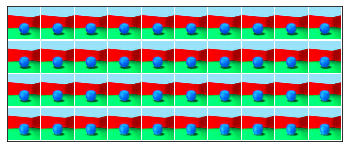

In [368]:
samp = latent_sample[6]
s = samp.repeat(40,1)

b = torch.linspace(-1,1,40)
s[:,9]= b.view(40,)
show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1,nrow=10))

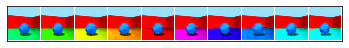

In [369]:
s = samp.repeat(10,1)
b = torch.linspace(-2,2,10)
s[:,2] = b.view(10,)
show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1,nrow=10))

In [370]:
# s = samp.repeat(40,1)
# s[:,4] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [371]:
# s = samp.repeat(40,1)
# s[:,7] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [372]:
# s = samp.repeat(40,1)
# s[:,9] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [373]:
# import matplotlib.pyplot as plt
# lis = test_labels.detach().numpy()[:,-1].tolist()
# liss = [x/32 for x in lis]
# plt.scatter(latent_dist[0].detach().numpy(), np.zeros((32,)), 
#             c = liss)

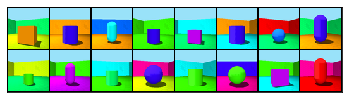

In [374]:
show(vutils.make_grid(valid_originals.cpu()))

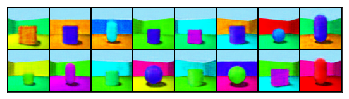

In [375]:
show(vutils.make_grid(valid_reconstructions.cpu().data))

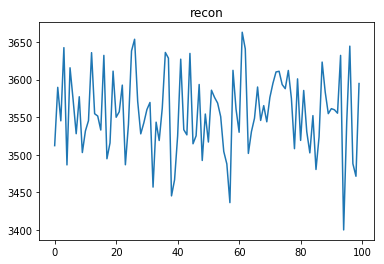

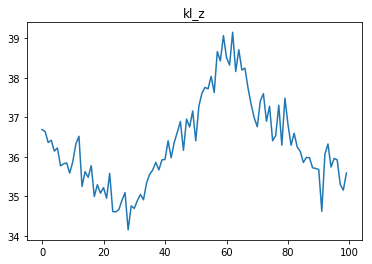

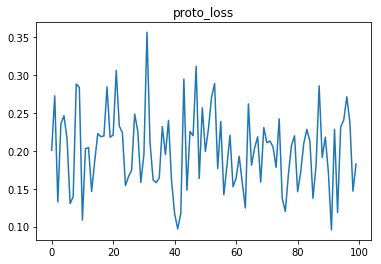

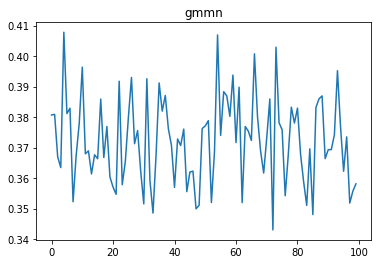

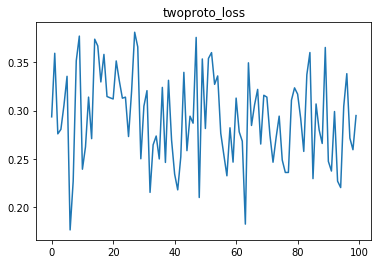

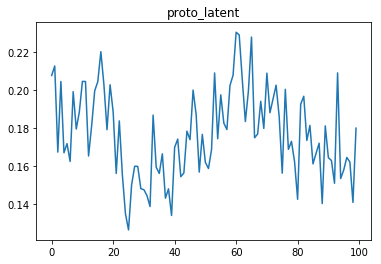

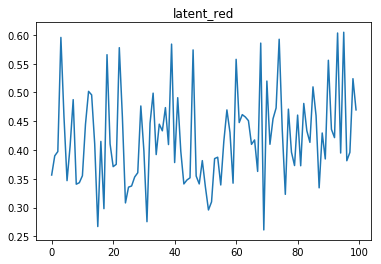

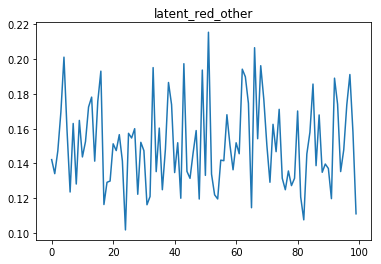

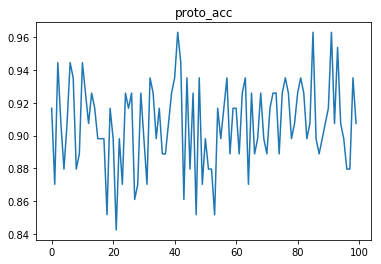

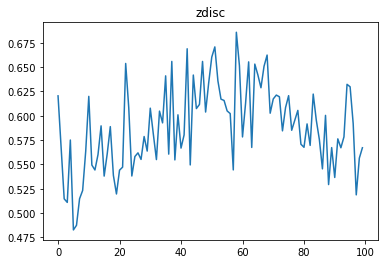

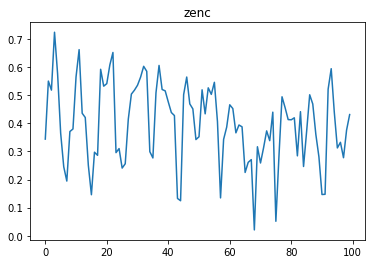

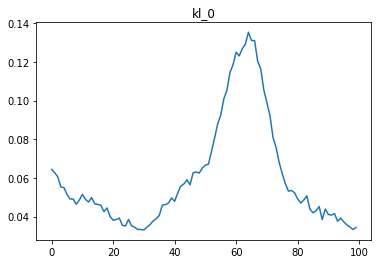

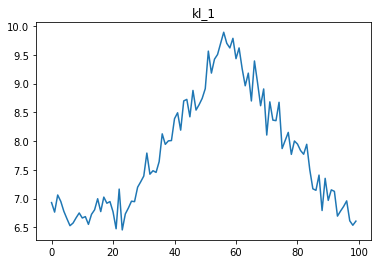

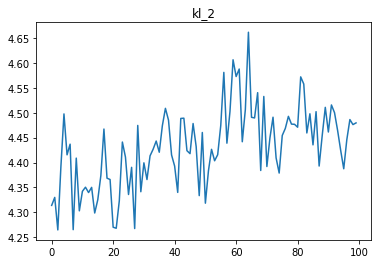

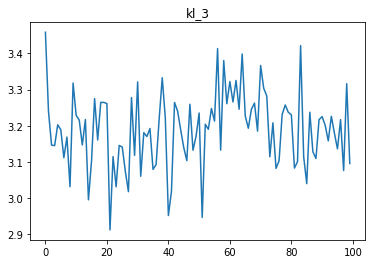

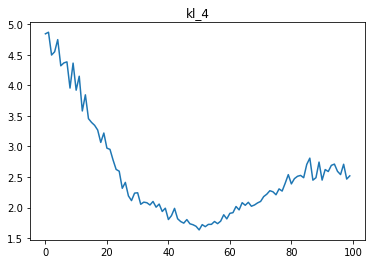

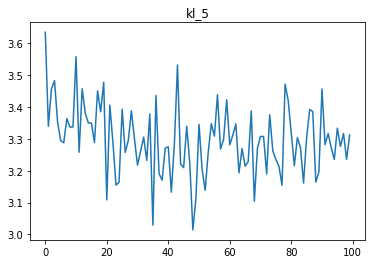

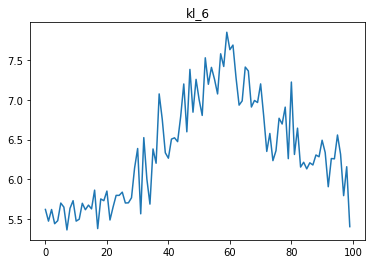

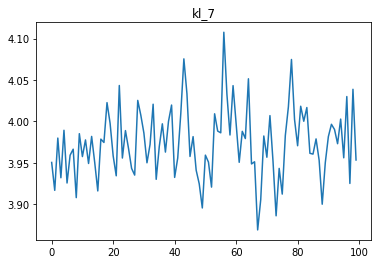

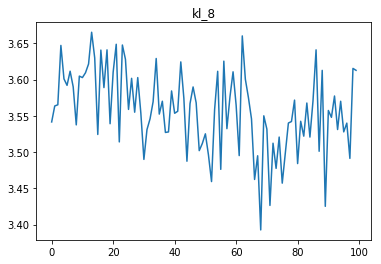

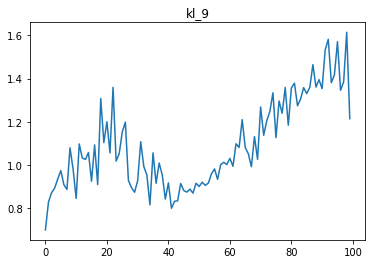

In [376]:
import json
import matplotlib.pyplot as plt

with open(loss_file) as f:
    data = json.load(f)

for key in list(data):
    plt.plot(data[key][-100:])
    plt.title(key)
    plt.show()

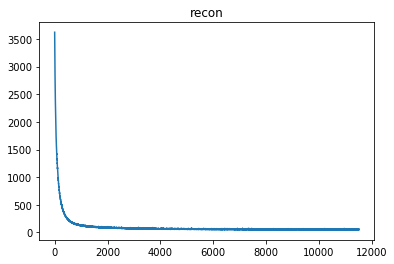

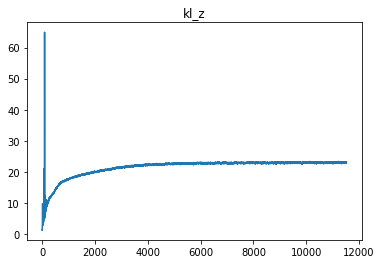

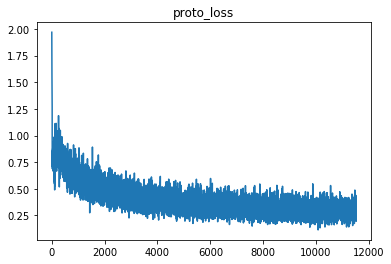

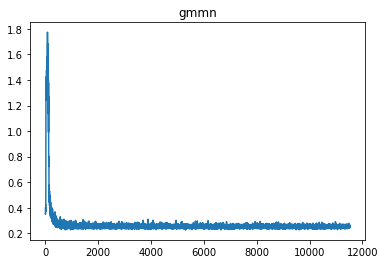

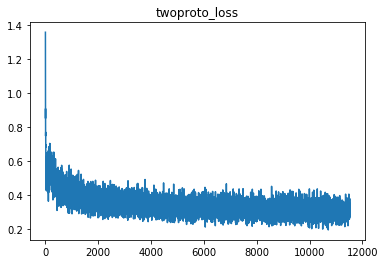

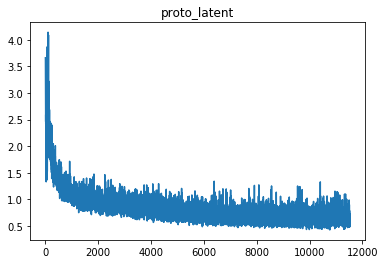

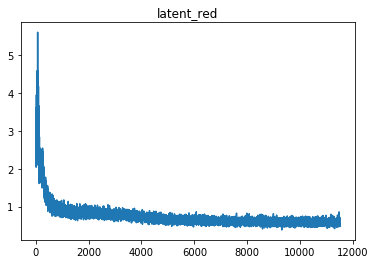

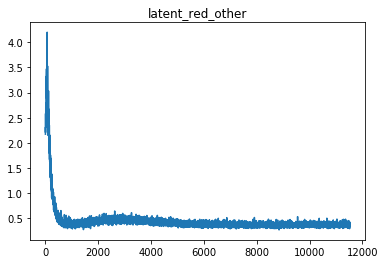

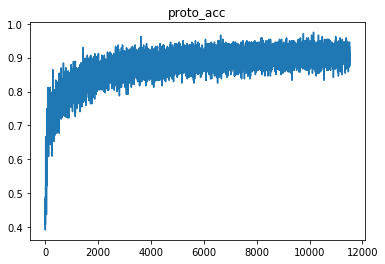

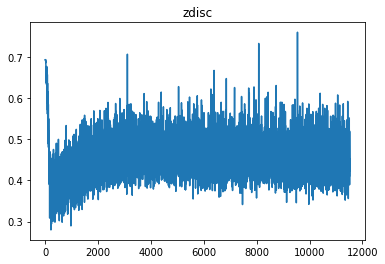

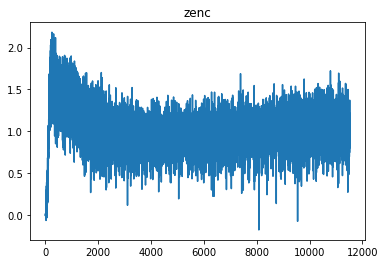

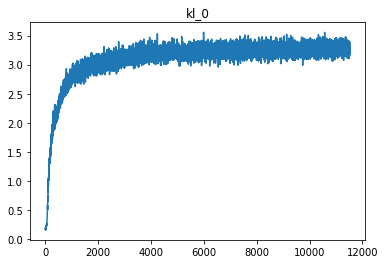

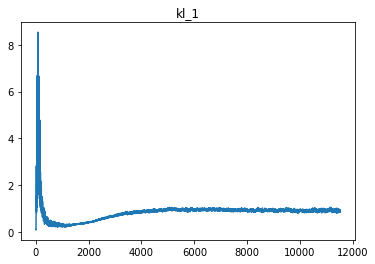

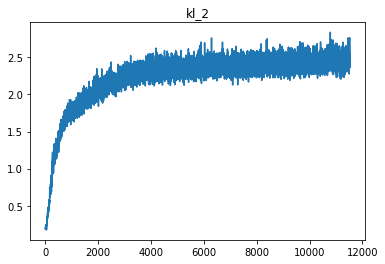

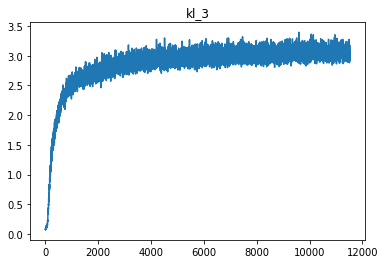

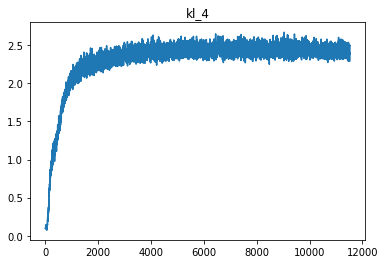

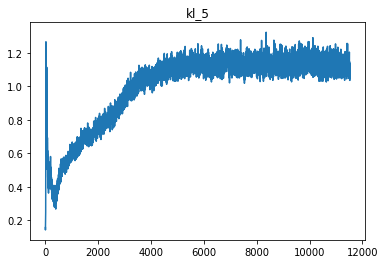

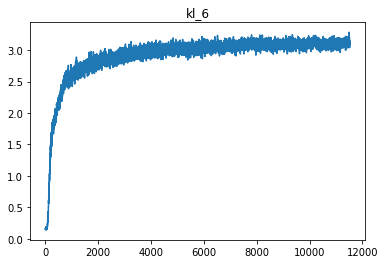

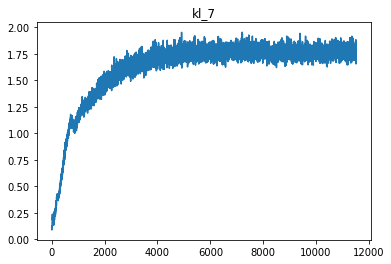

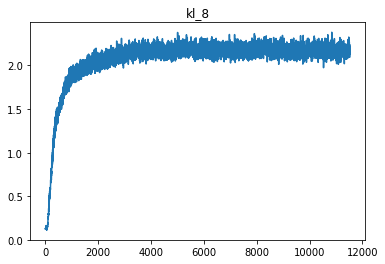

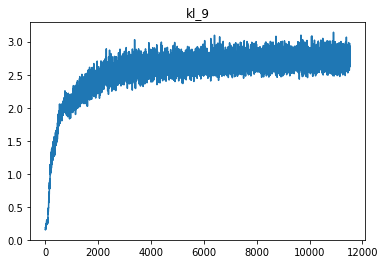

In [377]:
#name,epoch,z1+z2,beta,gan,lrg,lrd,batch_size,z2,args.flag,args.inter,
#args.cap,args.betamax,args.betamin,args.redecode,args.stepflag,args.klflag

import json
import matplotlib.pyplot as plt
with open('factdec2nrgantwolosses_e5_d10_b1_lrg0.0001_lrd5e-05_bs128_intperm_gan0_z2recons5_real1_f10_f20_red6.0.json') as f:
    data = json.load(f)

for key in list(data):
    plt.plot(data[key])
    plt.title(key)
    plt.show()

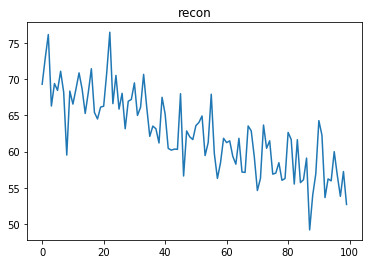

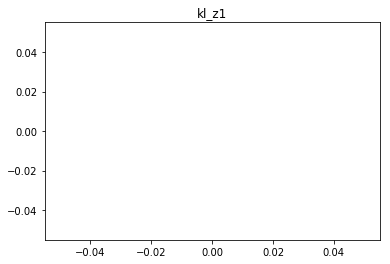

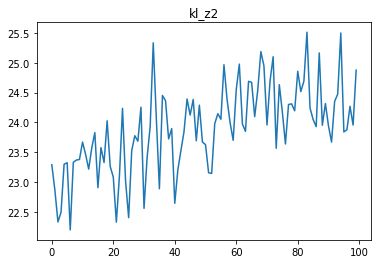

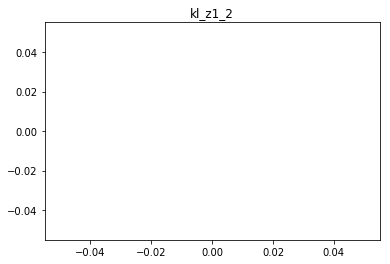

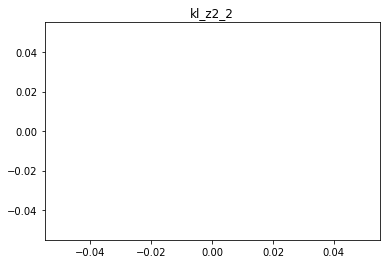

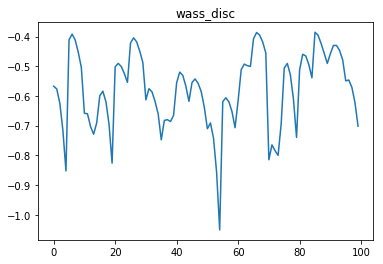

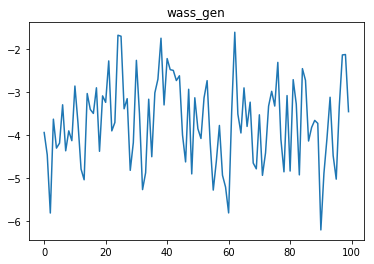

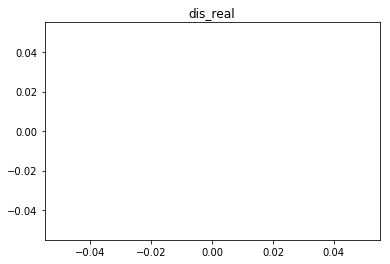

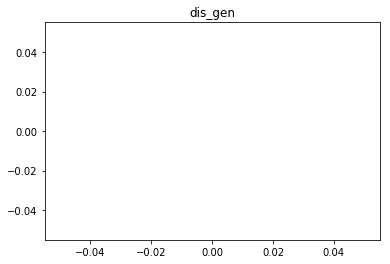

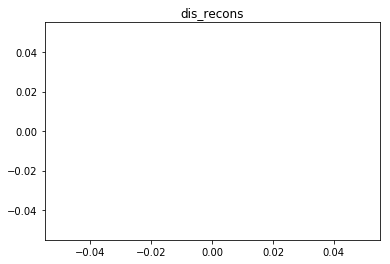

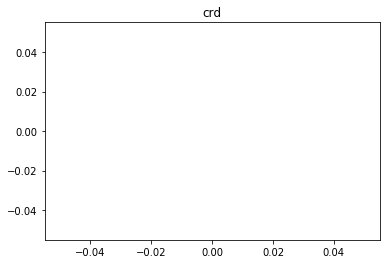

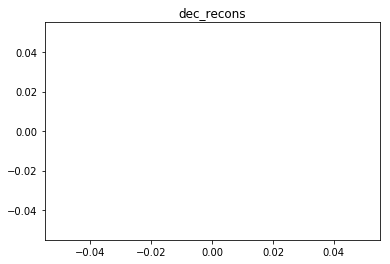

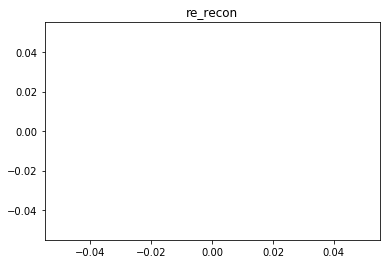

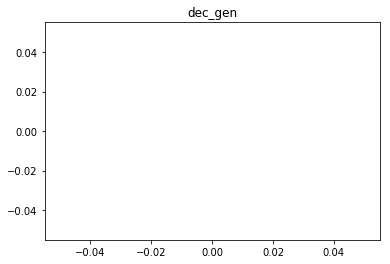

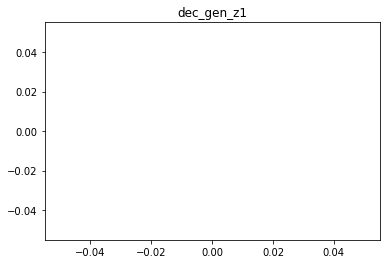

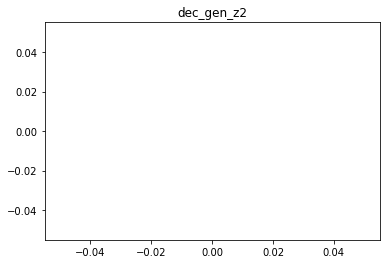

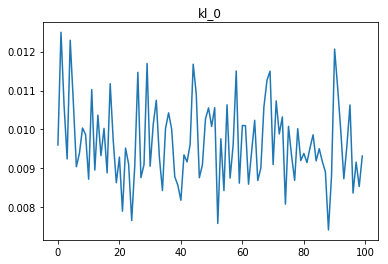

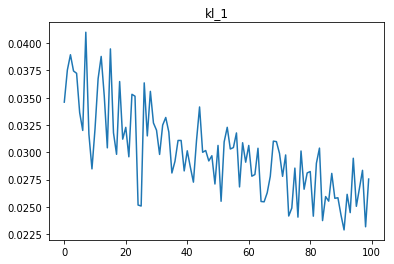

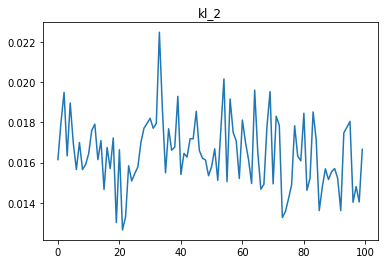

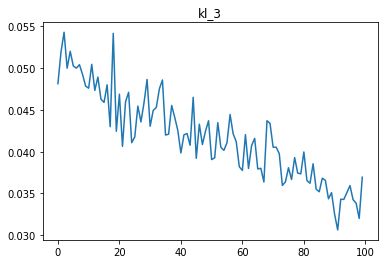

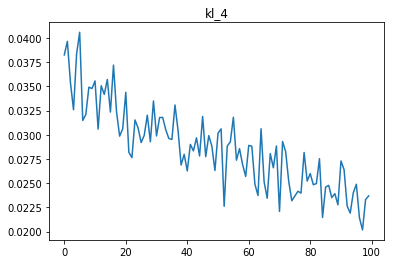

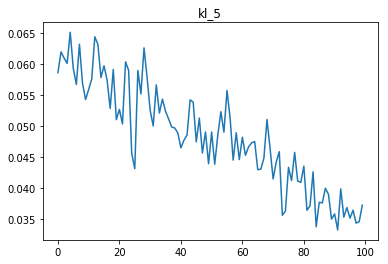

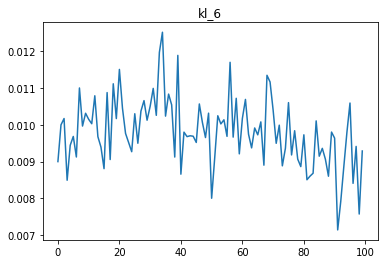

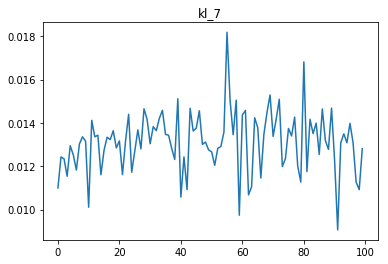

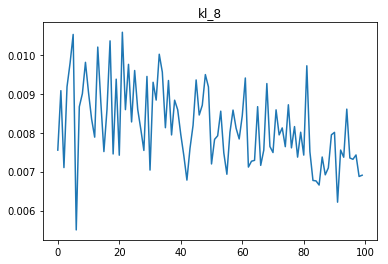

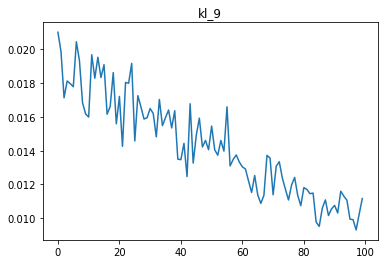

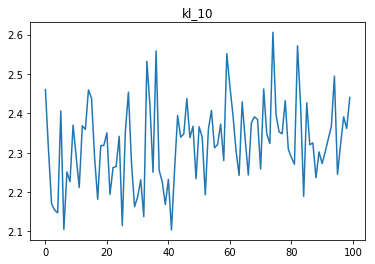

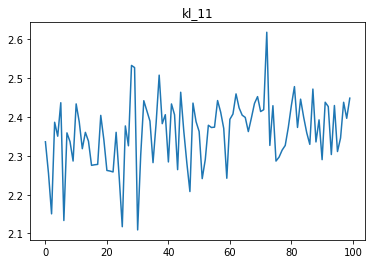

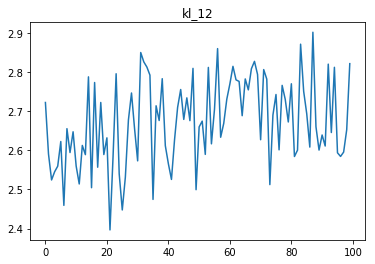

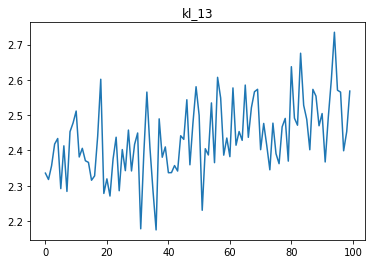

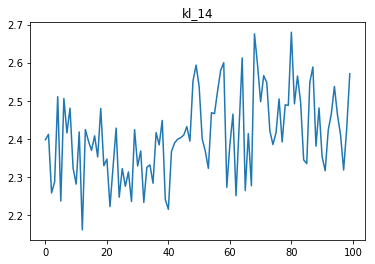

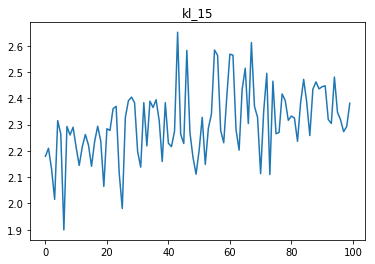

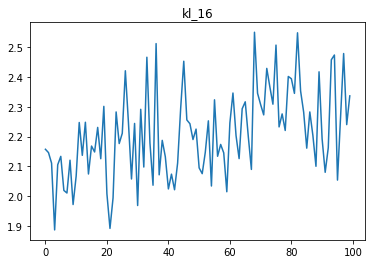

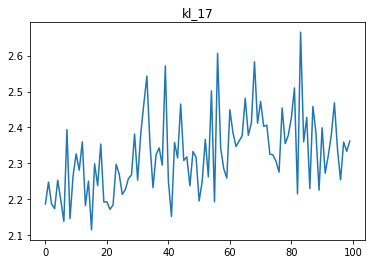

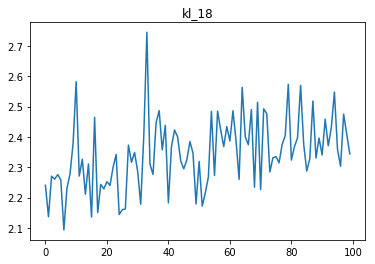

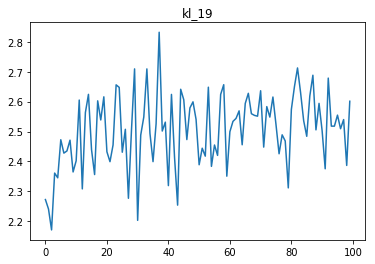

In [378]:
#name,epoch,z1+z2,beta,gan,lrg,lrd,batch_size,z2,args.flag,args.inter,
#args.cap,args.betamax,args.betamin,args.redecode,args.stepflag,args.klflag

import json
import matplotlib.pyplot as plt
with open('wassnoenc_two_abllosses_e5_d20_b1_g1_lrg5e-05_lrd5e-05_bs128_z210_f1_intprior_cap10_bmax0_bmin0.1_red0.0_sf0_kf0_z2recons1_real100_cr0.json') as f:
    data = json.load(f)

for key in list(data):
    plt.plot(data[key][-100:])
    plt.title(key)
    plt.show()

In [379]:
# around the same?
# epochs = 5
# non zero lat = [1,2,5,8,9,11,12,14]
# zero lat = [0,3,4,6,7,10,13,15]

# epochs = 2. 7,8
# non zero lat = [3,4,5,6,13,14,15,8,7]
# nzero_lat = [0,1,2,9,10,11,12]

In [380]:
# print(torch.exp((latent_dist[1])))

In [381]:
# print((latent_dist[0]))

In [382]:
# discriminator/AdamOptimizer.beta1 = 0.5
# discriminator/AdamOptimizer.beta2 = 0.9

In [383]:
#for future use
mlogvar = 0

KLD = -0.5 * torch.sum(1 + logvar -mlogvar - mu.pow(2)/mlogvar.exp() - logvar.exp() + mlogvar.exp())

NameError: name 'logvar' is not defined

In [ ]:
# for future use
k = torch.randint(5,(20,1))
print(k)
z = torch.rand((20,5))
print(z)
import numpy as np

In [ ]:
def sample_different(z, batch_size,k,alpha=1):
    with torch.no_grad():
        alpha = np.ones(shape=(batch_size, 1)) * alpha
        data = z.gather(1, k.view(-1,1))
        sign = torch.where(data>0,-1,1)
        data = data + sign*alpha
        t = z.scatter(1,k,data.float())
    return t

In [ ]:
print(sample_different(z,20,k,alpha=1))

In [ ]:
import torch

In [ ]:
z = torch.randn((50,10))

In [ ]:
k = torch.randint(5,(50,1))

In [ ]:
def sample_farthest(z, batch_size,k):
    t = z.clone()
    with torch.no_grad():
        data = z.gather(1, k)
        cd = {}
        f = torch.randn(k.shape)
        for i in range(5): # change this hard coded 5
            
            # collect the data points that need to be changed
            cd[i] = data[k==i]
            
            m = torch.cdist(cd[i].view(-1,1),z[:,i].view(-1,1),p=2.0)
            
            # example that is the farthest
            _,ind = torch.max(m,dim=1)
            
            # get the mean of that index
            val = z[ind,i]
            f[k==i] = val        
    t = t.scatter(1,k,f)
    return t

In [ ]:
# sample randomly from the top k some and then choose which one to take, not multiple ones
def sample_kfarthest(z, batch_size,k):
    t = z.clone()
    with torch.no_grad():
        data = z.gather(1, k)
        cd = {}
        f = torch.randn(k.shape)
        for i in range(5):
            cd[i] = data[k==i]
            m = torch.cdist(cd[i].view(-1,1),z[:,i].view(-1,1),p=2.0)
            # increasing number of factors (i+1 factors)
            _,ind = torch.topk(m,i+1,dim=1)
            print(ind)
            val = z[ind[:,i],i]
            f[k==i] = val        
    t = t.scatter(1,k,f)
    return t

In [ ]:
# print(z[:5])
# print(k[:5])
print(sample_kfarthest(z,50,k).shape)
# print(ind)

In [ ]:
# with a gap implement next if it makes a difference
def sample_farthest(z, batch_size,k, gap):
    t = z.clone()
    with torch.no_grad():
        data = z.gather(1, k)
        cd = {}
        f = torch.randn(k.shape)
        for i in range(5): # change this hard coded 5
            
            # collect the data points that need to be changed
            cd[i] = data[k==i]
            
            m = torch.cdist(cd[i].view(-1,1),z[:,i].view(-1,1),p=2.0)
            
            
            # example that is the farthest
            _,ind = torch.max(m,dim=1)
            
            # get the mean of that index
            val = z[ind,i]
            f[k==i] = val        
    t = t.scatter(1,k,f)
    return t

In [ ]:
# print(k[:5])

In [ ]:
t = z.gather(1,k)
      
      #[k==2].shape)
      #[:,k==2,:,:,:,])

In [ ]:

print(t[k==4].shape)

In [ ]:
b = torch.cdist(t[k==4].view(-1,1),z[:,4].view(-1,1),p=2.0)
# print(b)

In [ ]:
#c = b.gather(1,torch.argmax(b,dim=1).view(-1,1))

In [ ]:
#once you get cdist, you get the indices

_,ind = torch.max(b,dim=1)

In [ ]:
f = torch.randn(k.shape)

In [ ]:
import torch

In [ ]:
k = torch.randn(10,10)
print(k)

In [ ]:
print(torch.sigmoid(k))

In [ ]:
if self.model.is_continuous:
            # Calculate KL divergence
            mean, logvar = latent_dist['cont']
            kl_cont_loss = self._kl_normal_loss(mean, logvar)
            # Linearly increase capacity of continuous channels
            cont_min, cont_max, cont_num_iters, cont_gamma = \
                self.cont_capacity
            # Increase continuous capacity without exceeding cont_max
            cont_cap_current = (cont_max - cont_min) * self.num_steps / float(cont_num_iters) + cont_min
            cont_cap_current = min(cont_cap_current, cont_max)
            # Calculate continuous capacity loss
            cont_capacity_loss = cont_gamma * torch.abs(cont_cap_current - kl_cont_loss)

        if self.model.is_discrete:
            # Calculate KL divergence
            kl_disc_loss = self._kl_multiple_discrete_loss(latent_dist['disc'])
            # Linearly increase capacity of discrete channels
            disc_min, disc_max, disc_num_iters, disc_gamma = \
                self.disc_capacity
            # Increase discrete capacity without exceeding disc_max or theoretical
            # maximum (i.e. sum of log of dimension of each discrete variable)
            disc_cap_current = (disc_max - disc_min) * self.num_steps / float(disc_num_iters) + disc_min
            disc_cap_current = min(disc_cap_current, disc_max)
            # Require float conversion here to not end up with numpy float
            disc_theoretical_max = sum([float(np.log(disc_dim)) for disc_dim in self.model.latent_spec['disc']])
            disc_cap_current = min(disc_cap_current, disc_theoretical_max)
            # Calculate discrete capacity loss
            disc_capacity_loss = disc_gamma * torch.abs(disc_cap_current - kl_disc_loss)


In [ ]:
# import numpy as np 
# import torch 
# import torch.nn as nn 
# import torch.nn.functional as F 
# from torch_geometric.nn import GATConv
# import torch_geometric.transforms as T 
# import pygsp 
# torch.manual_seed(2020)

In [ ]:
# class GAT(nn.Module):
# 	def __init__(self, in_channel, nclasses):
# 		super(GAT, self).__init__()
# 		self.hid = 8
# 		self.in_head = 8
# 		self.out_head = 1
# 		self.in_channel = in_channel
# 		self.nclasses = nclasses
# 		self.conv1 = GATConv(self.in_channel, self.hid, heads=self.in_head, dropout = 0.6)
# 		self.conv2 = GATConv(self.hid*self.in_head, self.nclasses, concat=False, heads = self.out_head, dropout = 0.6)

# 	def forward(self, signal, adj):
# 		# x, edge_index = data.x, data.edge_index
# 		print('hereee')
# # 		signal = signal.cuda()
# # 		adj = adj.cuda()
# 		singal = signal.float()
# 		adj = adj.float()
# 		print('signal type: ',signal.dtype)
# 		print('adj type: ', adj.dtype)
# 		x = F.dropout(signal, p=0.6, training=self.training)
# 		print('heree1')
# 		x = self.conv1(x, adj)
# 		print('heree2')
# 		x = F.relu(x)
# 		print('heree3')
# 		x = F.dropout(x, p=0.6, training=self.training)
# 		print('heree4')
# 		x = self.conv2(x, adj)
# 		print('heree5')
# 		return F.log_softmax(x, dim=1)

In [ ]:
import json
import matplotlib.pyplot as plt
with open('losses_20_15_1_1_0.0001_256_10_1_2_1_0_3000.json') as f:
    data = json.load(f)

for key in list(data):
    plt.plot(data[key][:5000])
    plt.title(key)
    plt.show()

In [ ]:
a = torch.randn((10,20))

In [ ]:
a

In [ ]:
b = torch.mean(a, dim=0)

In [ ]:
c = b.view(1,-1)

In [ ]:
c.shape

In [ ]:
d = c.repeat(10,1)

In [ ]:
d

In [ ]:
a = [1,2,4]

In [ ]:
print(*a)

In [ ]:
def sums(x,y,z):
    return x+y+z

In [ ]:
sums(*a)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import h5py

In [ ]:
dataset = h5py.File('3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

In [ ]:
imgs = n

In [ ]:
import torch

In [ ]:
a = torch.randperm(10)

In [ ]:
a

In [ ]:
b = torch.rand((20,10))

In [ ]:
b

In [ ]:
torch.gather(b,1,a.view(-1,1))

In [ ]:
import numpy as np

In [ ]:
a = np.random.rand(10,1,3)

In [ ]:
a.shape

In [ ]:
labels = np.random.randint(10, size = (10,1))

In [ ]:
#labels.reshape(10,1)

In [ ]:
labels.shape

In [ ]:
labs = np.reshape(labels,(10,))

In [ ]:
labs.shape

In [ ]:
a[labels==2].shape

In [ ]:
g = []

In [ ]:
g = []

for i in range(2):
    g.append(np.random.rand(10,2))

In [ ]:
t = np.concatenate(g)

In [ ]:
t.shape

In [ ]:
import torch

In [ ]:
embedding={}
for i in range(2):
    embedding[i] = torch.nn.Embedding(2**(i+2), 1)
    embedding[i].weight = torch.nn.Parameter(torch.linspace(-1, 1, 2**(i+2), device ="cpu"),requires_grad=False)

In [ ]:
print(embedding[0].weight)
print(embedding[1].weight)

In [ ]:
encodings={}

In [ ]:
data = torch.randn(12,2)
print(data)
quantized = torch.zeros(12,2)

In [ ]:
for i in range(2):
    distances = torch.cdist(data[:,i:i+1].unsqueeze(-1), embedding[i].weight.unsqueeze(0).repeat(12,1).unsqueeze(-1), p=2)
    encoding_indices = torch.argmin(distances, dim=2)
    encodings[i] = torch.zeros(encoding_indices.shape[0], 2**(i+2), device="cpu")
    encodings[i].scatter_(1, encoding_indices, 1)
    quantized[:,i] = torch.matmul(encodings[i], embedding[i].weight)

In [ ]:
print(quantized)

In [ ]:
print(encodings)

In [ ]:
import numpy as np

In [ ]:
a = np.random.rand(10,2)
b = np.random.rand(10,2)
c = np.random.rand(10,2)

In [ ]:
a.shape

In [ ]:
t = [a,b,c]

In [ ]:
z = np.vstack(t)

In [ ]:
z.shape

In [ ]:
a = [1,2,3,4]

In [ ]:
name = 'vae'
with open('{}.txt'.format(name), "w") as output:
    output.write(str(a))

In [ ]:
a = [1,2,3,4]
b = str(a)

In [ ]:
b

In [ ]:
import ast
c = ast.literal_eval(b)

In [ ]:
sum(c)

In [ ]:
a = [1,2,3]

In [ ]:
# I did not know this. 
a += [5]

In [ ]:
a

In [ ]:
import torch

In [ ]:
a = torch.tensor([2.0],requires_grad=True)

In [ ]:
b = a**2

In [ ]:
c = 2*b

In [ ]:
grad = torch.autograd.grad(c,a)

In [ ]:
print(int(grad[0].item()))

In [ ]:
grad

In [ ]:
x = torch.randn(1,1,128,128)

In [ ]:
x.shape

In [ ]:
net = torch.nn.Sequential(torch.nn.Conv2d(1,4,(3,3)), nn.MaxPool2d(2,2),
                          torch.nn.Conv2d(4,16,(3,3)), nn.MaxPool2d(2,2), 
                          nn.Flatten())

In [ ]:
y = net(x)

In [ ]:
print(y.shape)

In [ ]:
a = {}

In [ ]:
a['apples'] = 3

In [ ]:
a['bananas'] = 4

In [ ]:
a = torch.randn(2,4)

In [ ]:
a.shape

In [ ]:
a.unsqueeze(1).repeat(10,1,1).shape

In [ ]:
a.unsqueeze(1).repeat(10,1,1).shape

In [ ]:
a = torch.randn(128,2)

In [ ]:
c = a[:-(128%10)]

In [ ]:
latent_disc = torch.arange(128).view(128,1).repeat(1,10)

In [ ]:
def sample_proto(latent_disc, bs, inter, cat=True):
    #gen_sample = self.sample_gen(latent_disc).clone().detach()
    gen_sample = latent_disc
    gen_sample = gen_sample[:-(bs%10)]
    num_s = gen_sample.shape[0]//2
    q = (bs//10)//2
    a = torch.randperm(bs-(bs%10))
    anchor_s = gen_sample[a][:num_s]
    anchor_q = gen_sample[a][num_s:]
    gen_s = []
    gen_q = []
    for i in range(10):
        if inter=='prior':
            datas = torch.randn(q, requires_grad = False)
            anchor_s_z = anchor_s[q*i:q*(i+1)].clone()
            anchor_s_z[:,i] = datas
            gen_s.append(anchor_s_z)
            anchor_q_z = anchor_q[q*i:q*(i+1)].clone()
            anchor_q_z[:,i] = datas
            gen_q.append(anchor_q_z)
        if inter=='perm':
            b = torch.randperm(num_s)
            datas = anchor_s[:,i][b][:q]
            anchor_s_z = anchor_s[q*i:q*(i+1)].clone()
            anchor_q_z = anchor_q[q*i:q*(i+1)].clone()
            anchor_s_z[:,i] = datas
            print(anchor_s_z,'anchor_s_z')
            anchor_q_z[:,i] = datas
            print(anchor_q_z,'anchor_q_z')
            gen_s.append(anchor_s_z)
            gen_q.append(anchor_q_z)

    if cat:
        support = torch.cat(gen_s, dim=0).unsqueeze(1)
        query = torch.cat(gen_q, dim=0).unsqueeze(1)
    else:
        support = torch.stack(gen_s)
        query = torch.stack(gen_q)
    return support, query, a, num_s, q

In [ ]:
latent_disc.shape

In [ ]:
gen_zs, gen_zq, a, num_s, q = sample_proto(latent_disc, 128, 'perm', cat=True)

In [ ]:
print(gen_zs.shape, gen_zq.shape)

In [ ]:
gen_z = torch.cat((gen_zs.view(10*q, *gen_zs.size()[2:]),gen_zq.view(10*q, *gen_zq.size()[2:])),dim=0)
gen = gen_z

In [ ]:
data = latent_disc

In [ ]:
dataps = data[:-(128%10)][a][:num_s]
datapq = data[:-(128%10)][a][num_s:]

In [ ]:
dataps

In [ ]:
datapq

In [ ]:
samples = {}
if True:
    samples['xs'] = torch.cat((gen[:10*q].view(gen_zs.size()[0], gen_zs.size()[1], 10),
                                       dataps.unsqueeze(1)), dim=-1)
    samples['xq'] = torch.cat((gen[10*q:].view(gen_zq.size()[0], gen_zq.size()[1], 10),
                                       datapq.unsqueeze(1)), dim=-1)


In [ ]:
print(samples['xs'][12])

In [ ]:
print(samples['xq'][12])

In [ ]:
bloc = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )

In [ ]:
a = torch.randn(20,1,24,24)

In [ ]:
bloc(a).shape

In [ ]:
a = torch.randn(4, requires_grad=True)

In [ ]:
a

In [ ]:
b = torch.randn(1, requires_grad=True)

In [ ]:
loss1 = torch.sum(a**2)

In [ ]:
# a.requires_grad = False

In [ ]:
loss2 = torch.mean(a**2) + b

In [ ]:
# a.requires_grad = True

In [ ]:
(loss2 + loss1).backward()

In [ ]:
a.grad

In [ ]:
b.grad

In [ ]:
c = torch.tensor(a.data, requires_grad=True)

In [ ]:
loss1 = torch.sum(c**2)
loss1.backward()

In [ ]:
supp = torch.randn(4, 4, 10, requires_grad=True)

In [ ]:
que = torch.randn(4, 8, 10, requires_grad=True)

In [ ]:
def euclidean_dist(x, y):
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

class Protonet(nn.Module):
    def __init__(self):
        super(Protonet, self).__init__()

        self.encoder = nn.Sequential(nn.Linear(10,2),nn.ReLU())

    def loss(self, supp, que):
        xs = supp # support
        xq = que # query

        n_class = xs.size(0)
        assert xq.size(0) == n_class
        n_support = xs.size(1)
        n_query = xq.size(1)

        target_inds = torch.arange(0, n_class).view(n_class, 1, 1).expand(n_class, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)

        if xq.is_cuda:
            target_inds = target_inds.cuda()

        x = torch.cat([xs.view(n_class * n_support, *xs.size()[2:]),
                       xq.view(n_class * n_query, *xq.size()[2:])], 0)

        z = self.encoder.forward(x)
        z_dim = z.size(-1)

        # change the loss function to include how far the the individual encodings are from the mean
        z_proto_p = z[:n_class*n_support].view(n_class, n_support, z_dim)
        z_proto = torch.mean(z_proto_p, dim=1)
        zq = z[n_class*n_support:]

        # see how the loss changes if detach is used and if it isn't used
        dists = euclidean_dist(zq, z_proto)
        with torch.no_grad():
            euc_loss = euclidean_dist(z_proto_p.view(-1,z_dim), z_proto)
        log_p_y = F.log_softmax(-dists, dim=1).view(n_class, n_query, -1)

        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()

        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()

        return loss_val, euc_loss, {
            'loss': loss_val.item(),
            'acc': acc_val.item()
        }

In [ ]:
protonet = Protonet()

In [ ]:
opt = optim.Adam(protonet.encoder.parameters(), lr=0.01)

In [ ]:
for i in range(10):
    opt.zero_grad()
    loss1, loss2, _ = protonet.loss(supp,que)
    print(loss1)
    print(loss2)
    loss1.backward()
    opt.step()

In [ ]:
loss = euclidean_dist(query, proto)

In [ ]:
with torch.no_grad():
    dis = euclidean_dist(supp.view(-1,2), proto)    

In [ ]:
loss.backward()

In [ ]:
print(loss)

In [ ]:
a = torch.randint(5,(20,1))

In [ ]:
print(sum(a==2).item())

In [ ]:
a = torch.rand((10,30))

In [ ]:
b = torch.rand((10,30))

In [ ]:
loss = F.binary_cross_entropy(a,b,reduction='none')

In [ ]:
loss.shape

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=16, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(10, 32, 16)
out = transformer_encoder(src)

In [ ]:
print(out.shape)